# Задание № 6

Обучить сиамскую сеть для верификации лиц на датасете LFW.
Библиотеки: [Python, Tensorflow]

Датасет LabeledFacesintheWild [LFW](http://vis-www.cs.umass.edu/lfw/#explore) содержит 13233 изображений
5749 персон. Данный набор формировался специально для проведения тестирования алгоритмов распознавания лиц. LFW содержит специальный тестовый список из 6000 пар изображений, разделѐнный на 10 частей, по 300 совпадающих пар и по 3

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import imageio
from skimage.transform import resize
%matplotlib inline

## Загрузка LFW

> Загрузка датасета с помощью [Tensor Flow Datasets](https://www.tensorflow.org/datasets/catalog/lfw)

In [2]:
# tfds.disable_progress_bar()
(label_train, img_train), (label_test, img_test) = tfds.load( 
    'lfw',
    split=['train[:90%]', 'train[90%:]'],
    batch_size=-1,
    as_supervised=True,
    shuffle_files=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/lfw/0.1.0.incomplete6RVVTX/lfw-train.tfrecord*...:   0%|          | 0/1323…

Dataset lfw downloaded and prepared to /root/tensorflow_datasets/lfw/0.1.0. Subsequent calls will reuse this data.


In [3]:
print(f'Image size: {img_train.shape[1:]}')
print(f'Train exemples: {img_train.shape[0]}')
print(f'Test examples: {img_test.shape[0]}')

Image size: (250, 250, 3)
Train exemples: 11910
Test examples: 1323


In [4]:
# вычислим количество классов
classes = np.unique(np.concatenate((label_train, label_test)))
print(f'Number unique classes: {len(classes)}')

Number unique classes: 5749


## Анализ датасета

In [5]:
uniq, counts = np.unique(label_test, return_counts=True)

In [8]:
counts[::-1].sort()
counts[:200]

array([45, 25, 17, 15, 11,  9,  8,  7,  6,  6,  6,  5,  5,  5,  5,  5,  5,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

### Вывод
Датасет очень маленький для обученя, Практически есть только около 10 наполненый класса

## Визуализация

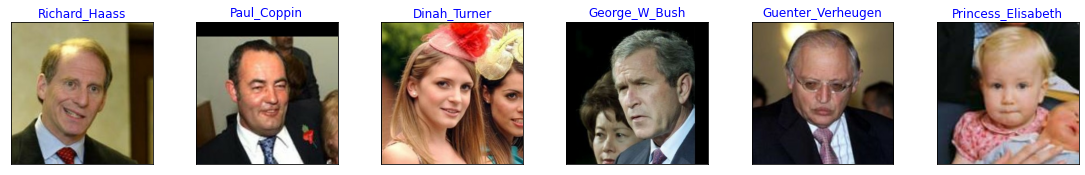

In [11]:
some_samples = [img_train[x] for x in range(10, 10+6)]
some_labels = [label_train[x] for x in range(10, 10+6)]

fig = plt.figure(figsize=(26, 12))
for j in range(len(some_samples)):
    ax = fig.add_subplot(4, 8, j + 1)
    ax.imshow(some_samples[j])
    ax.set_title(some_labels[j].numpy().decode('ascii'), c='blue')
    plt.xticks([]), plt.yticks([])
plt.show()

## Процедура подготовки данных

In [12]:
INP_SIZE = img_train.shape[1]
NUM_EPOCHS = 3
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
BUFFER_SIZE = 1000


def resize_images(img, label):
    img = tf.cast(img, tf.float32) / 255. 
    return tf.image.resize(img, (INP_SIZE, INP_SIZE)), label


# общая обработка тренировочной выборки
img_train = tf.data.Dataset.from_tensor_slices((img_train, label_train))
img_train = img_train.map(resize_images, num_parallel_calls=AUTOTUNE)
img_train = img_train.repeat(NUM_EPOCHS)
img_train = img_train.batch(BATCH_SIZE)

## Создание модели CNN

> Выходной вектор 128 мерный

In [17]:
EMB_SIZE = 128

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),  # функция активации не нужна
])

## Расчет функции потерь contrastive_loss

In [21]:
MARGIN = 20.0

def contrastive_loss(embs, labels):
    bs = embs.shape[0]
    embs1 = embs[:bs//2, :]  # часть эмбеддингов 32
    embs2 = embs[bs//2:, :]  # 2-я часть эмбеддингов 32
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)  # вектор размера 32
    d =  tf.sqrt(d2)  # вектор размера 32
    z = tf.cast(labels1 == labels2, tf.float32)  # вектор размера 32
    
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)  # одно число для целого батча

LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

## Обучение модели

In [22]:
%%time

for iteration, (images, labels) in enumerate(img_train):
    
    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value = contrastive_loss(embs, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    if iteration % 200 == 0:
        print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))

[0] Loss: 354.9896240234375
[200] Loss: 6.6958909034729
[400] Loss: 0.0
[600] Loss: 0.0
[800] Loss: 0.0
[1000] Loss: 0.0
CPU times: user 1min 12s, sys: 14.3 s, total: 1min 26s
Wall time: 5min 17s


## Сравнение эмбеддингов

In [23]:
# функция расчета евклидова расстояния
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

In [24]:
# посмотрим, какие классы встречаются несколько раз
labels_for_compare = [i for i in classes if len(np.where(label_test == i)[0]) > 1]

In [25]:
labels_for_compare[:3]

[b'Adrien_Brody', b'Alejandro_Toledo', b'Alex_Sink']

In [26]:
# выберем один класс
test_pos = np.where(label_test == b'Alejandro_Toledo')[0]
test_pos

array([ 383,  568, 1146])

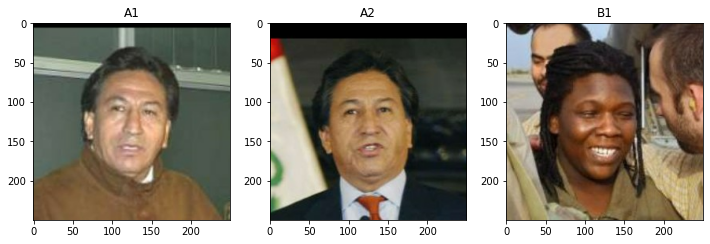

In [27]:
# визуализируем изображения одного класса и разных из тестовой выборки

img_a1 = img_test[568]
img_a2 = img_test[1146]
img_b1 = img_test[100]

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(img_a1)
ax.set_title('A1')
ax = fig.add_subplot(1, 3, 2)
ax.imshow(img_a2)
ax.set_title('A2')
ax = fig.add_subplot(1, 3, 3)
ax.imshow(img_b1)
ax.set_title('B1')
plt.show()

In [28]:
# рассчитаем эмбеддинги и посмотрим на итоговые расстояния между изображениями
new_embs = model(np.stack((img_a1, img_a2, img_b1), axis=0))

emb1 = new_embs[0,:]
emb2 = new_embs[1,:]
emb3 = new_embs[2,:]

print('A1 <-> A2: ', diff(emb1, emb2))
print('A2 <-> B1: ', diff(emb2, emb3))
print('A1 <-> B1: ', diff(emb1, emb3))

A1 <-> A2:  6959.241050574408
A2 <-> B1:  11032.305289466929
A1 <-> B1:  8238.3658573773


### Вывод

Расстояния показывают, что модель довольно плохо уловила принципы разделения классов.

In [29]:
# посмотрим на эмбеддинги 100 тестовых экземпляров
test_embs = model(img_test[:100])

## Визуализация чистых данных с помощью снижения размерности TNSE

In [30]:
test_x_flat = img_test.numpy().reshape(-1, 250*250)
test_x_2D = TSNE(n_components=2).fit_transform(test_x_flat[:100])  # отобразить в 2-хмерное пространство
labels_for_viz = label_test[:100].numpy()

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


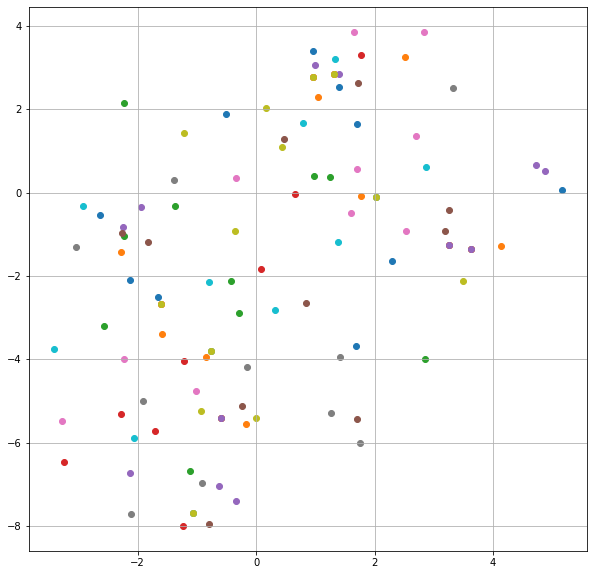

In [31]:
def draw_embeddings(X_embedded, targets, labels):
    plt.figure(figsize=(10, 10))
    for class_idx in targets:
        X_embedded_class = X_embedded[targets == class_idx, :]
        plt.scatter(X_embedded_class[:,0], X_embedded_class[:,1])
    # plt.legend(labels, loc='best')
    plt.grid(True)

draw_embeddings(test_x_2D, labels_for_viz, labels_for_viz)

## Визуализация эмбеддингов данных с помощью снижения размерности TNSE

In [32]:
test_embs_2D = TSNE(n_components=2).fit_transform(test_embs)
labels_for_viz = label_test[:100].numpy()

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


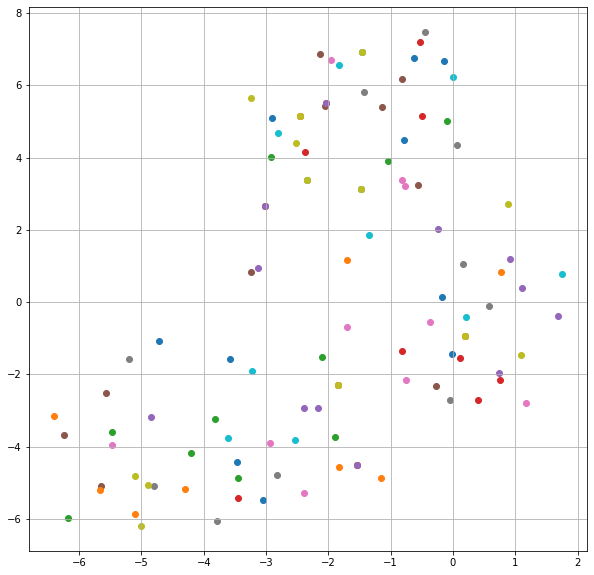

In [33]:
draw_embeddings(test_embs_2D, labels_for_viz, labels_for_viz)

### Вывод

Графики подтверждают, что модель плохо уловила закономерности верификации лиц. Есть некоторое упорядочивание, но оно слабое. Вероятно, классов слишком много, а изображений слишком мало для статистического просчета.